# Data Augmentation

Module 1, Lab 3

In this lab, we will see how augmentation of data samples help in improving the machine learning performance. Augmentation is the process of creating new data samples by making reasonable modifications to the original data samples. This is particularly useful when the size of the training data is small. We will use the MNISt dataset for this lab. We will also reuse functions from the previous labs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp

rng = np.random.default_rng(seed=42)

In [2]:
# loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# normalizing the data
train_X = train_X / 255
test_X = test_X / 255

# subsample from images and labels. Otherwise it will take too long!
train_X = train_X[::1200, :, :].copy()
train_y = train_y[::1200].copy()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Let us borrow a few functions from the previous labs:

In [3]:
def NN1(traindata, trainlabel, query):
    """
    This function takes in the training data, training labels and a query point
    and returns the predicted label for the query point using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    query: numpy array of shape (d,) where d is the number of features

    returns: the predicted label for the query point which is the label of the training data which is closest to the query point
    """
    diff = (
        traindata - query
    )  # find the difference between features. Numpy automatically takes care of the size here
    sq = diff * diff  # square the differences
    dist = sq.sum(1)  # add up the squares
    label = trainlabel[np.argmin(dist)]
    return label


def NN(traindata, trainlabel, testdata):
    """
    This function takes in the training data, training labels and test data
    and returns the predicted labels for the test data using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    testdata: numpy array of shape (m,d) where m is the number of test samples and d is the number of features

    returns: the predicted labels for the test data which is the label of the training data which is closest to each test point
    """
    traindata = traindata.reshape(-1, 28*28)
    testdata = testdata.reshape(-1, 28*28)
    predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
    return predlabel


def Accuracy(gtlabel, predlabel):
    """
    This function takes in the ground-truth labels and predicted labels
    and returns the accuracy of the classifier

    gtlabel: numpy array of shape (n,) where n is the number of samples
    predlabel: numpy array of shape (n,) where n is the number of samples

    returns: the accuracy of the classifier which is the number of correct predictions divided by the total number of predictions
    """
    assert len(gtlabel) == len(
        predlabel
    ), "Length of the ground-truth labels and predicted labels should be the same"
    correct = (
        gtlabel == predlabel
    ).sum()  # count the number of times the groundtruth label is equal to the predicted label.
    return correct / len(gtlabel)

-1: In the reshape() method, -1 is a placeholder that tells NumPy to automatically calculate the size of this dimension based on the size of the array and the sizes of the other specified dimensions. In this case, it will figure out the number of images.
28*28: This calculates the product of 28 and 28, which is 784. This means the second dimension of the reshaped array will have a size of 784.

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time. Let us first check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [4]:
testpred = NN(train_X, train_y, test_X)
print("Baseline accuracy without augmentation:",
      Accuracy(test_y, testpred)*100, "%")

Baseline accuracy without augmentation: 64.72 %


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits. So, we will use the following augmentations:

### Augmentation 1: Rotation

Let us try rotating the image a little. We will use the `rotate` function from the `skimage` module. We will rotate the image by 10 degrees and -10 degrees. Rotation is a reasonable augmentation because the digit will still be recognizable even after rotation and is representative of the dataset.

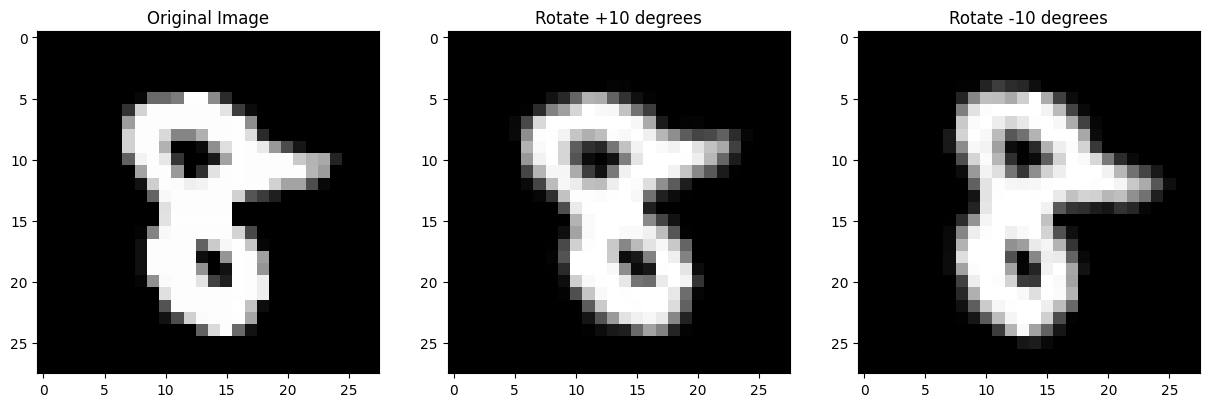

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(train_X[2], cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(rotate(train_X[2], 10), cmap="gray")
axs[1].set_title("Rotate +10 degrees")

axs[2].imshow(rotate(train_X[2], -10), cmap="gray")
axs[2].set_title("Rotate -10 degrees")

plt.show()

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [6]:
def augRotate(sample, angleconstraint):
    """
    This function takes in a sample and an angle constraint and returns the augmented sample
    by rotating the sample by a random angle within the angle constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    angleconstraint: the maximum angle by which the sample can be rotated

    returns: the augmented sample which is the input sample rotated by a random angle within the angle constraint
    """
    if angleconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(sample[ii], angle[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

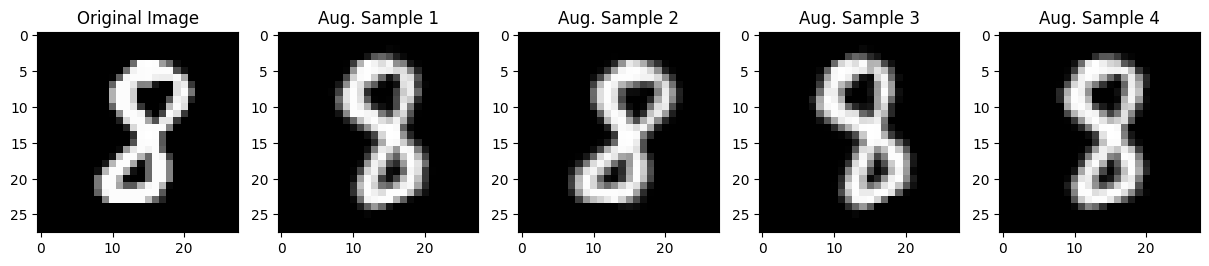

In [7]:
sample = train_X[20]
angleconstraint = 70

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[1].set_title("Aug. Sample 1")

axs[2].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[2].set_title("Aug. Sample 2")

axs[3].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[3].set_title("Aug. Sample 3")

axs[4].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[4].set_title("Aug. Sample 4")

plt.show()

Let us augment the whole dataset and see if this improves the test accuracy

In [8]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X  # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
    augdata = np.concatenate(
        (augdata, augRotate(train_X, angleconstraint))
    )  # concatenate the augmented data to the set
    auglabel = np.concatenate(
        (auglabel, train_y)
    )  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print("Accuracy after rotation augmentation:", Accuracy(test_y, testpred)*100, "%")

Accuracy after rotation augmentation: 67.66 %


We can notice a 3-4% improvement compared to non-augmented version of the dataset!

The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint. We will try angles between 0 and 90 degrees. We can also try different multiples of the original dataset. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [9]:
angleconstraints = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # the values we want to test
accuracies = np.zeros(
    len(angleconstraints), dtype=float
)  # we will save the values here

for ii in range(len(angleconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotate(train_X, angleconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after rotation augmentation constrained by",
        angleconstraints[ii],
        "degrees is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after rotation augmentation constrained by 0 degrees is 64.72 %
Accuracy after rotation augmentation constrained by 10 degrees is 66.79 %
Accuracy after rotation augmentation constrained by 20 degrees is 67.84 %
Accuracy after rotation augmentation constrained by 30 degrees is 68.47 %
Accuracy after rotation augmentation constrained by 40 degrees is 67.63 %
Accuracy after rotation augmentation constrained by 50 degrees is 67.65 %
Accuracy after rotation augmentation constrained by 60 degrees is 65.3 %
Accuracy after rotation augmentation constrained by 70 degrees is 66.06 %
Accuracy after rotation augmentation constrained by 80 degrees is 64.61 %
Accuracy after rotation augmentation constrained by 90 degrees is 64.31 %


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

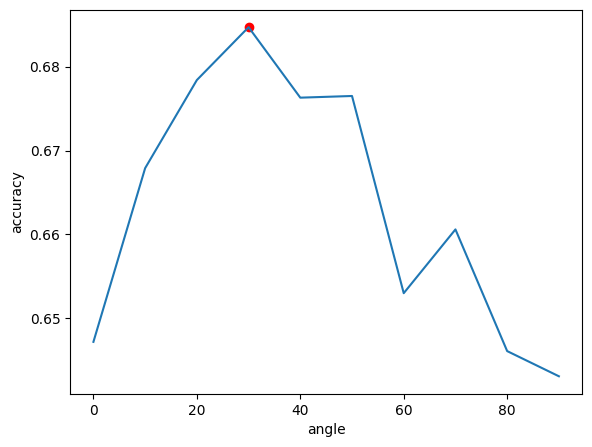

In [10]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 2: Shear


Let us try one more augmentation: shear. Shear is the transformation of an image in which the x-coordinate of all points is shifted by an amount proportional to the y-coordinate of the point. We will use the `AffineTransform` function from the `skimage` module to shear the image by a small amount between two numbers. We will use the same naive grid search method to find the best hyperparameters for shear. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [11]:
def shear(sample, amount):
    """
    This function takes in a sample and an amount and returns the augmented sample
    by shearing the sample by the given amount

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    amount: the amount by which the sample should be sheared

    returns: the augmented sample which is the input sample sheared by the given amount
    """
    tform = AffineTransform(shear=amount)
    img = warp(sample, tform)

    # Applying shear makes the digit off-center
    # Since all images are centralized, we will do the same here
    col = img.sum(0).nonzero()[0]
    row = img.sum(1).nonzero()[0]
    if len(col) > 0 and len(row) > 0:
        xshift = int(sample.shape[0] / 2 - (row[0] + row[-1]) / 2)
        yshift = int(sample.shape[1] / 2 - (col[0] + col[-1]) / 2)
        img = np.roll(img, (xshift, yshift), (0, 1))
    return img

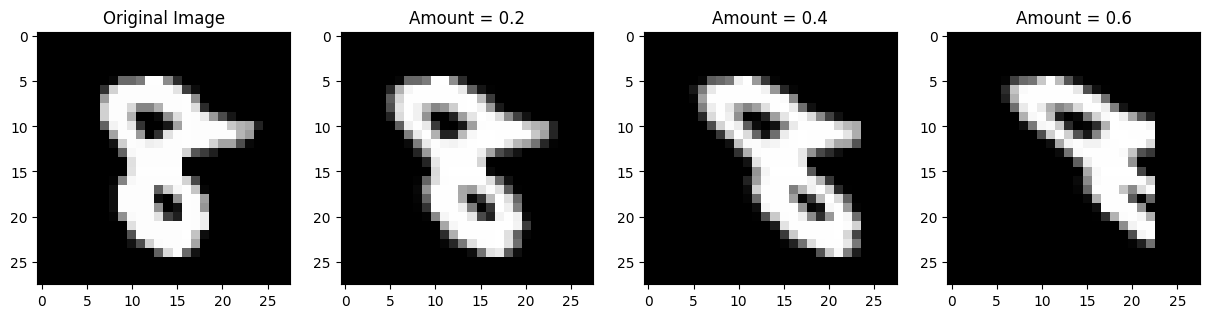

In [12]:
sample = train_X[2]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(shear(sample, 0.2), cmap="gray")
axs[1].set_title("Amount = 0.2")

axs[2].imshow(shear(sample, 0.4), cmap="gray")
axs[2].set_title("Amount = 0.4")

axs[3].imshow(shear(sample, 0.6), cmap="gray")
axs[3].set_title("Amount = 0.6")

plt.show()

Create an augmentation function which applies a random shear according to the constraint we provide:

In [13]:
def augShear(sample, shearconstraint):
    """
    This function takes in a sample and a shear constraint and returns the augmented sample
    by shearing the sample by a random amount within the shear constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    shearconstraint: the maximum shear by which the sample can be sheared

    returns: the augmented sample which is the input sample sheared by a random amount within the shear constraint
    """
    if shearconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = shear(sample[ii], amt[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [14]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
    1.8,
    2.0,
]  # the values we want to test
accuracies = np.zeros(
    len(shearconstraints), dtype=float
)  # we will save the values here

for ii in range(len(shearconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augShear(train_X, shearconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after shear augmentation constrained by",
        shearconstraints[ii],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after shear augmentation constrained by 0 is 64.72 %
Accuracy after shear augmentation constrained by 0.2 is 62.79 %
Accuracy after shear augmentation constrained by 0.4 is 64.41 %
Accuracy after shear augmentation constrained by 0.6 is 65.71000000000001 %
Accuracy after shear augmentation constrained by 0.8 is 65.78 %
Accuracy after shear augmentation constrained by 1.0 is 65.42999999999999 %
Accuracy after shear augmentation constrained by 1.2 is 63.6 %
Accuracy after shear augmentation constrained by 1.4 is 63.65 %
Accuracy after shear augmentation constrained by 1.6 is 61.809999999999995 %
Accuracy after shear augmentation constrained by 1.8 is 63.029999999999994 %
Accuracy after shear augmentation constrained by 2.0 is 64.14 %


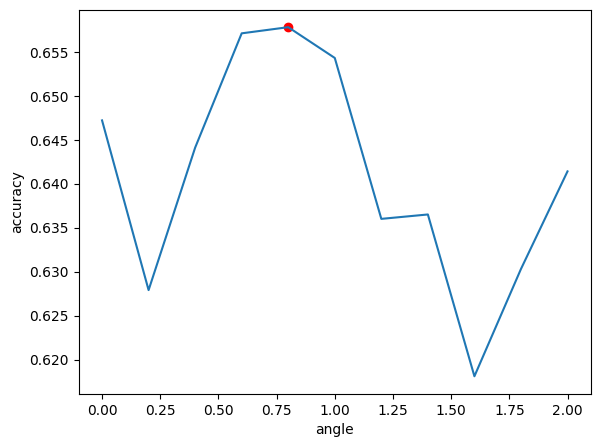

In [15]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 3: Rotation + Shear



We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [16]:
def augRotateShear(sample, angleconstraint, shearconstraint):
    """
    This function takes in a sample, an angle constraint and a shear constraint and returns the augmented sample
    by rotating the sample by a random angle within the angle constraint and shearing the sample by a random amount within the shear constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    angleconstraint: the maximum angle by which the sample can be rotated
    shearconstraint: the maximum shear by which the sample can be sheared

    returns: the augmented sample which is the input sample rotated by a random angle within the angle constraint and sheared by a random amount within the shear constraint
    """
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(
            shear(sample[ii], amt[ii]), angle[ii]
        )  # first apply shear, then rotate
    return np.squeeze(nsample)  # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [17]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
]  # the values we want to test
angleconstraints = [0, 10, 20, 30, 40, 50, 60]  # the values we want to test
# cartesian product of both
hyp = cartesian((shearconstraints, angleconstraints))

accuracies = np.zeros(len(hyp), dtype=float)  # we will save the values here

for ii in range(len(hyp)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after augmentation shear:",
        hyp[ii][0],
        "angle:",
        hyp[ii][1],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after augmentation shear: 0.0 angle: 0.0 is 63.32 %
Accuracy after augmentation shear: 0.0 angle: 10.0 is 63.959999999999994 %
Accuracy after augmentation shear: 0.0 angle: 20.0 is 60.64000000000001 %
Accuracy after augmentation shear: 0.0 angle: 30.0 is 63.019999999999996 %
Accuracy after augmentation shear: 0.0 angle: 40.0 is 64.14999999999999 %
Accuracy after augmentation shear: 0.0 angle: 50.0 is 61.72 %
Accuracy after augmentation shear: 0.0 angle: 60.0 is 63.7 %
Accuracy after augmentation shear: 0.2 angle: 0.0 is 63.41 %
Accuracy after augmentation shear: 0.2 angle: 10.0 is 61.25000000000001 %
Accuracy after augmentation shear: 0.2 angle: 20.0 is 60.6 %
Accuracy after augmentation shear: 0.2 angle: 30.0 is 60.07 %
Accuracy after augmentation shear: 0.2 angle: 40.0 is 63.690000000000005 %
Accuracy after augmentation shear: 0.2 angle: 50.0 is 60.12 %
Accuracy after augmentation shear: 0.2 angle: 60.0 is 63.72 %
Accuracy after augmentation shear: 0.4 angle: 0.0 is 63.37000

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

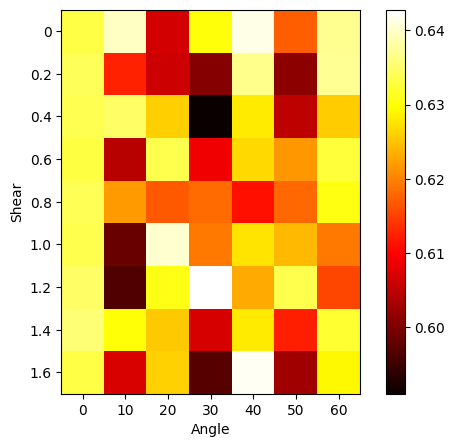

In [18]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
im = ax.imshow(
    accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap="hot"
)
ax.set_xlabel("Angle")
ax.set_ylabel("Shear")
ax.set_xticks(np.arange(len(angleconstraints)))
ax.set_xticklabels(angleconstraints)
ax.set_yticks(np.arange(len(shearconstraints)))
ax.set_yticklabels(shearconstraints)
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?

ANS:


  a.without aug = 64.72%

  b.max rotAUG = 68.47%(30 degrees)

  c.max sheAUG = 65.42% (0.8)

  d.max sherotAUG = 63.57%(shear = 1.4 and angle = 0)

  e.from b and c, with 30 degree roation and 0.8 shear the accuracy doesn't necessarily improve it is (58.85%)





2.Can you increase the accuracy by increasing the number of augmentations from each sample?

ANS: We can and cannot, it depends upon the type of augmentation that we are using. in the above example, the augmentation of rotation and shear together didn't improve the overall accuracy.

3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

For the 3rd question, i've tried implementing Noise and colour Inversion. and also combined both of those.

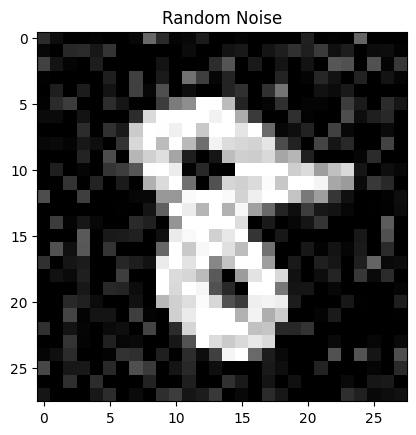

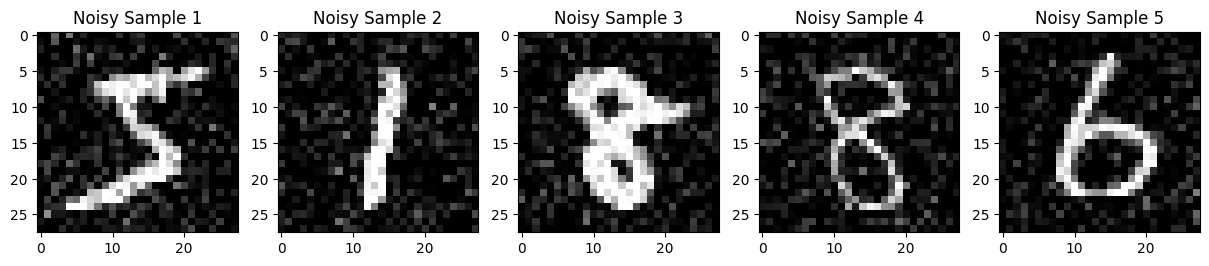

In [19]:
from skimage.util import random_noise

def augNoise(sample, sigma):
    """
    This function takes in a sample and a standard deviation (sigma) and returns the augmented sample
    by adding random noise to the sample.

    sample: numpy array of shape (n, d) where n is the number of samples and d is the number of features (or a single image)
    sigma: the standard deviation for the noise to be added.

    returns: the augmented sample with added random noise.
    """
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional (or 4 if adding noise to multiple images)
        sample = np.expand_dims(sample, 0)

    nsample = sample.copy()  # preallocate the augmented array to make it faster

    for ii in range(len(sample)):
        nsample[ii] = random_noise(sample[ii], var=sigma**2)

    return np.squeeze(nsample) # take care if the input had only one sample.

# Example usage with one image
sample = train_X[2]
sigma = 0.155

noisy_sample = augNoise(sample, sigma)

plt.imshow(noisy_sample, cmap='gray')
plt.title('Random Noise')
plt.show()

# Example usage with multiple images
# Let's take a few images from the training set
samples_for_noise = train_X[:5]
sigma = 0.155

noisy_samples = augNoise(samples_for_noise, sigma)

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    axs[i].imshow(noisy_samples[i], cmap='gray')
    axs[i].set_title(f'Noisy Sample {i+1}')

plt.show()

In [20]:
# hyperparameters for noise augmentation
sigma_constraint = 0.155  # You can experiment with this value
naugmentations = 5       # Number of augmented samples per original image

# create the augmented dataset
augdata_noise = train_X  # Start with the original images
auglabel_noise = train_y

for ii in range(naugmentations):
    augdata_noise = np.concatenate(
        (augdata_noise, augNoise(train_X, sigma_constraint))
    )  # concatenate the augmented data
    auglabel_noise = np.concatenate(
        (auglabel_noise, train_y)
    )  # labels remain the same

# check the test accuracy with noise augmentation
testpred_noise = NN(augdata_noise, auglabel_noise, test_X)
accuracy_noise = Accuracy(test_y, testpred_noise)

print(
    "Accuracy after noise augmentation with sigma =",
    sigma_constraint,
    "is",
    accuracy_noise * 100,
    "%",
    flush=True,
)

Accuracy after noise augmentation with sigma = 0.155 is 64.56 %


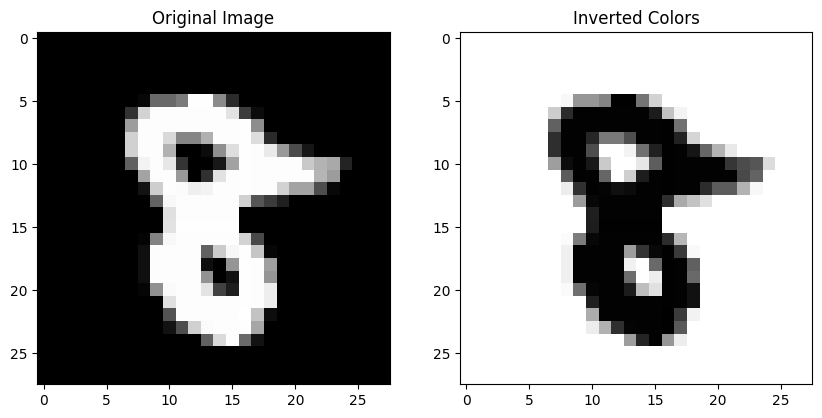

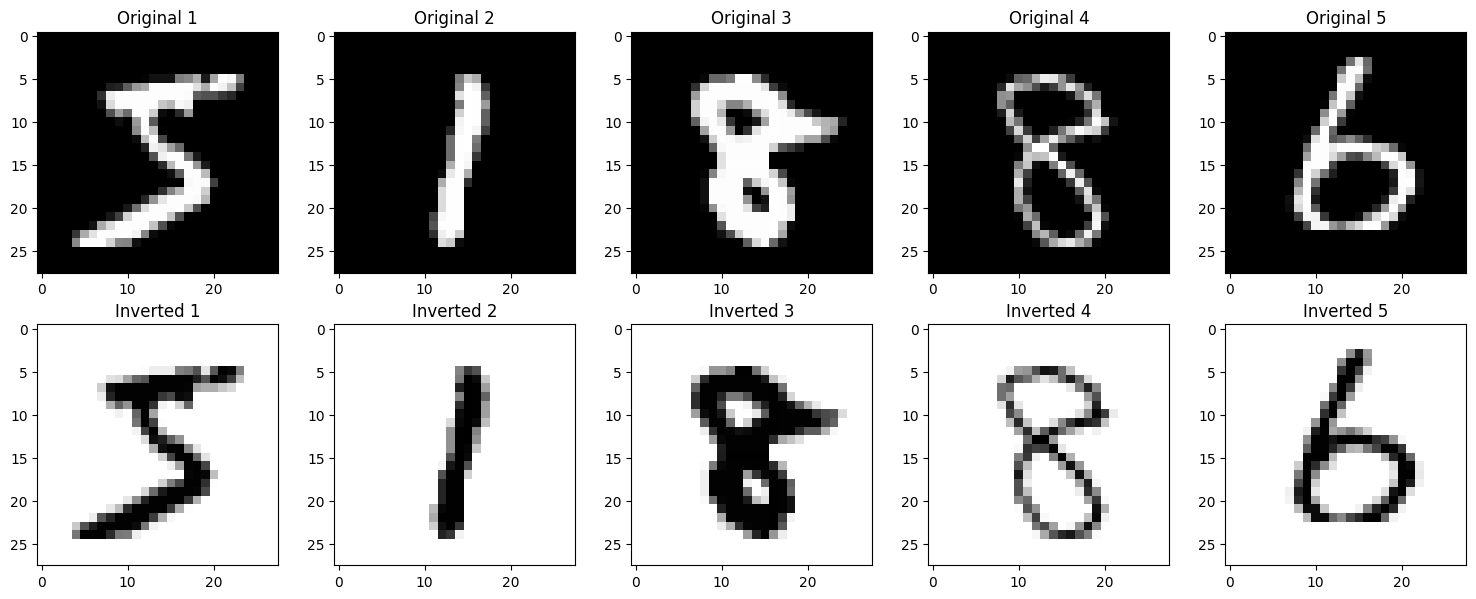

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def augInvertColors(sample):
    """
    This function takes in a sample (or array of samples) and returns the augmented sample
    by inverting the colors.

    For grayscale images, this means subtracting each pixel value from the maximum possible value (1.0 if normalized).

    sample: numpy array of shape (n, d) where n is the number of samples and d is the number of features (or a single image)

    returns: the augmented sample with inverted colors.
    """
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional (or 4 if processing multiple images)
        sample = np.expand_dims(sample, 0)

    nsample = 1.0 - sample # Assuming pixel values are normalized between 0 and 1

    return np.squeeze(nsample) # take care if the input had only one sample.

# Example usage with one image
sample = train_X[2]

inverted_sample = augInvertColors(sample)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(sample, cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(inverted_sample, cmap='gray')
axs[1].set_title('Inverted Colors')

plt.show()

# Example usage with multiple images
# Let's take a few images from the training set
samples_for_invert = train_X[:5]

inverted_samples = augInvertColors(samples_for_invert)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    axs[0, i].imshow(samples_for_invert[i], cmap='gray')
    axs[0, i].set_title(f'Original {i+1}')

    axs[1, i].imshow(inverted_samples[i], cmap='gray')
    axs[1, i].set_title(f'Inverted {i+1}')

plt.tight_layout()
plt.show()

In [32]:
# hyperparameters for color inversion augmentation
# For color inversion, there's typically no 'constraint' like angle or shear.
# We just need to decide how many inverted copies to add.
naugmentations_invert = 5 # Number of augmented samples per original image

# create the augmented dataset including color inversion
augdata_invert = train_X  # Start with the original images
auglabel_invert = train_y

for ii in range(naugmentations_invert):
    augdata_invert = np.concatenate(
        (augdata_invert, augInvertColors(train_X))
    )  # concatenate the augmented data
    auglabel_invert = np.concatenate(
        (auglabel_invert, train_y)
    )  # labels remain the same

print(f"Total number of samples in the inverted-augmented dataset: {augdata_invert.shape[0]}")

# check the test accuracy with color inversion augmentation
testpred_invert = NN(augdata_invert, auglabel_invert, test_X)
accuracy_invert = Accuracy(test_y, testpred_invert)

print(
    "Accuracy after color inversion augmentation is",
    accuracy_invert * 100,
    "%",
    flush=True,
)

Total number of samples in the inverted-augmented dataset: 300
Accuracy after color inversion augmentation is 64.72 %


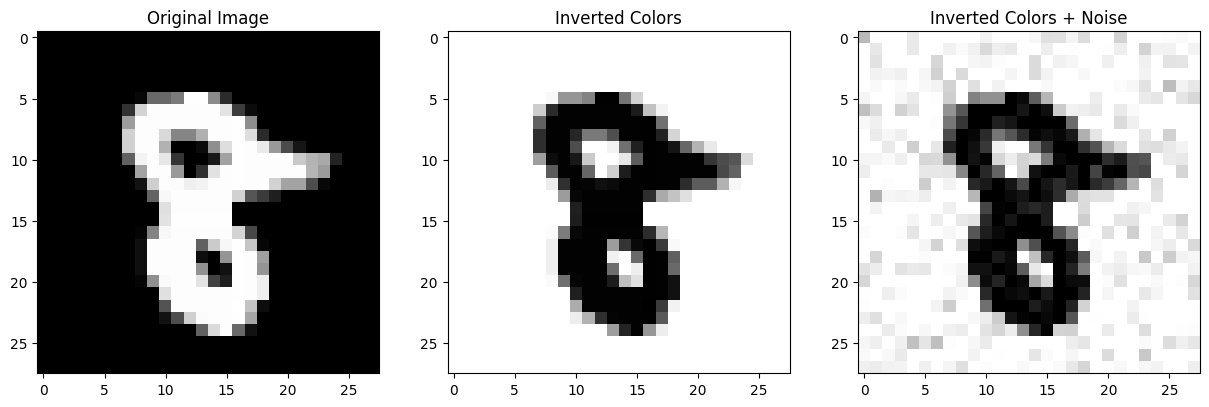

Total number of samples in the combined-augmented dataset: 300
Accuracy after combined color inversion and noise augmentation is 64.72 %


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise

def augInvertColorsAndNoise(sample, sigma):
    """
    This function takes in a sample and a standard deviation (sigma) and returns the augmented sample
    by inverting the colors and then adding random noise.

    sample: numpy array of shape (n, d) where n is the number of samples and d is the number of features (or a single image)
    sigma: the standard deviation for the noise to be added *after* inversion.

    returns: the augmented sample with inverted colors and added random noise.
    """
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional (or 4 if processing multiple images)
        sample = np.expand_dims(sample, 0)

    # Apply color inversion first
    inverted_sample = 1.0 - sample # Assuming pixel values are normalized between 0 and 1

    # Apply noise to the inverted sample
    nsample = inverted_sample.copy() # preallocate the augmented array
    for ii in range(len(inverted_sample)):
         nsample[ii] = random_noise(inverted_sample[ii], var=sigma**2)


    return np.squeeze(nsample) # take care if the input had only one sample.

# Example usage with one image
sample = train_X[2]
sigma = 0.1 # You can adjust this sigma for the combined effect

combined_augmented_sample = augInvertColorsAndNoise(sample, sigma)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(sample, cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(augInvertColors(sample), cmap='gray') # Show just inversion for comparison
axs[1].set_title('Inverted Colors')

axs[2].imshow(combined_augmented_sample, cmap='gray')
axs[2].set_title('Inverted Colors + Noise')

plt.show()

# hyperparameters for combined augmentation
sigma_for_combined = 0.155 # You can use the same or a different sigma value
naugmentations_combined = 5 # Number of augmented samples per original image

# create the augmented dataset including combined augmentation
augdata_combined = train_X  # Start with the original images
auglabel_combined = train_y

for ii in range(naugmentations_combined):
    augdata_combined = np.concatenate(
        (augdata_combined, augInvertColorsAndNoise(train_X, sigma_for_combined))
    )  # concatenate the augmented data
    auglabel_combined = np.concatenate(
        (auglabel_combined, train_y)
    )  # labels remain the same

print(f"Total number of samples in the combined-augmented dataset: {augdata_combined.shape[0]}")

# check the test accuracy with combined augmentation
testpred_combined = NN(augdata_combined, auglabel_combined, test_X)
accuracy_combined = Accuracy(test_y, testpred_combined)

print(
    "Accuracy after combined color inversion and noise augmentation is",
    accuracy_combined * 100,
    "%",
    flush=True,
)

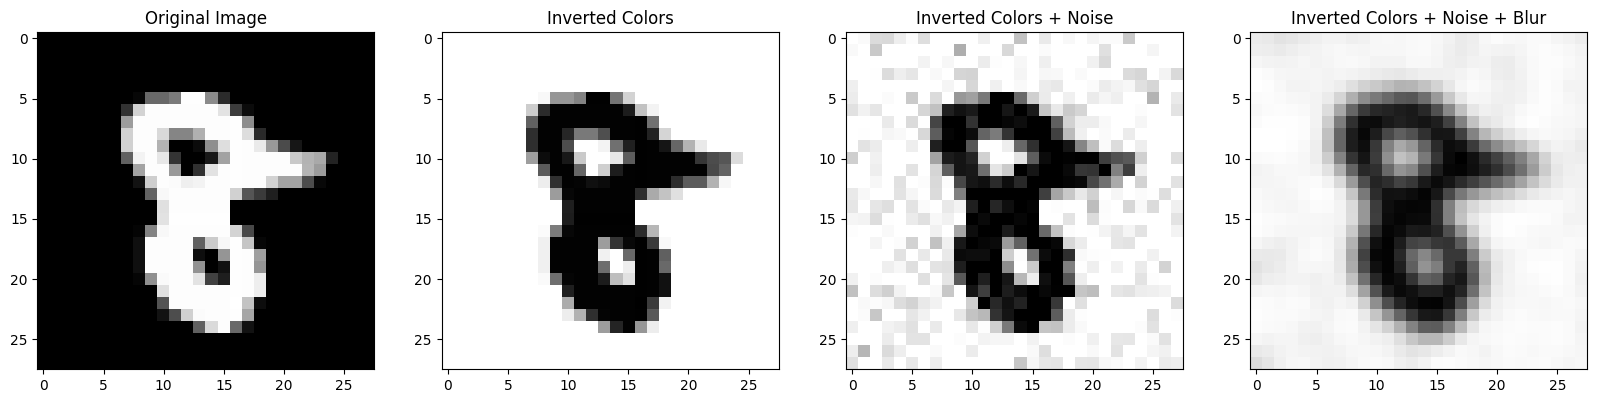

Total number of samples in the combined-augmented dataset: 300
Accuracy after combined color inversion, noise, and blur augmentation is 64.72 %


In [40]:
from IPython import get_ipython
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise, img_as_float # Import img_as_float
from skimage.filters import gaussian # Import gaussian

rng = np.random.default_rng(seed=42)

# loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# normalizing the data
train_X = train_X / 255
test_X = test_X / 255

# subsample from images and labels. Otherwise it will take too long!
train_X = train_X[::1200, :, :].copy()
train_y = train_y[::1200].copy()

# Borrowed functions from previous labs
def NN1(traindata, trainlabel, query):
    """
    This function takes in the training data, training labels and a query point
    and returns the predicted label for the query point using the nearest neighbour algorithm
    """
    diff = (traindata - query)
    sq = diff * diff
    dist = sq.sum(1)
    label = trainlabel[np.argmin(dist)]
    return label

def NN(traindata, trainlabel, testdata):
    """
    This function takes in the training data, training labels and test data
    and returns the predicted labels for the test data using the nearest neighbour algorithm
    """
    traindata = traindata.reshape(-1, 28*28)
    testdata = testdata.reshape(-1, 28*28)
    predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
    return predlabel

def Accuracy(gtlabel, predlabel):
    """
    This function takes in the ground-truth labels and predicted labels
    and returns the accuracy of the classifier
    """
    assert len(gtlabel) == len(predlabel), "Length of the ground-truth labels and predicted labels should be the same"
    correct = (gtlabel == predlabel).sum()
    return correct / len(gtlabel)

# Function for Color Inversion (re-included for completeness)
def augInvertColors(sample):
    """
    This function takes in a sample (or array of samples) and returns the augmented sample
    by inverting the colors.
    """
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    nsample = 1.0 - sample # Assuming pixel values are normalized between 0 and 1
    return np.squeeze(nsample)

# Function for Noise Augmentation (re-included for completeness)
def augNoise(sample, sigma):
    """
    This function takes in a sample and a standard deviation (sigma) and returns the augmented sample
    by adding random noise to the sample.
    """
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    nsample = sample.copy()
    for ii in range(len(sample)):
        nsample[ii] = random_noise(sample[ii], var=sigma**2)
    return np.squeeze(nsample)

# Combined Invert + Noise + Blur Augmentation Function
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise, img_as_float
from skimage.filters import gaussian

def augInvertNoiseBlur(sample, sigma, blur_sigma):
    """
    This function takes in a sample, standard deviation for noise, and sigma for blur,
    and returns the augmented sample by inverting colors, adding noise, and then blurring.

    sample: numpy array of shape (n, d) where n is the number of samples and d is the number of features (or a single image)
    sigma: the standard deviation for the noise to be added after inversion.
    blur_sigma: the standard deviation of the Gaussian kernel for blurring.

    returns: the augmented sample with inverted colors, added random noise, and blurring.
    """
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional (or 4 if processing multiple images)
        sample = np.expand_dims(sample, 0)

    # Apply color inversion first
    inverted_sample = 1.0 - sample # Assuming pixel values are normalized between 0 and 1

    # Apply noise to the inverted sample
    noisy_sample = inverted_sample.copy() # preallocate the augmented array
    for ii in range(len(inverted_sample)):
         noisy_sample[ii] = random_noise(inverted_sample[ii], var=sigma**2)

    # Apply blur to the noisy and inverted sample
    blurred_sample = noisy_sample.copy()
    for ii in range(len(noisy_sample)):
        # Ensure the image is a floating-point type before blurring
        image_to_blur = img_as_float(noisy_sample[ii])
        # Applying Gaussian blur to each image - removed multichannel=False
        blurred_sample[ii] = gaussian(image_to_blur, sigma=blur_sigma)

    return np.squeeze(blurred_sample) # take care if the input had only one sample.

# Rest of your code (example usage and training) remains the same.
# ... (your example usage and training code here)ne sample.


# Example usage with one image
sample = train_X[2]
sigma = 0.1 # Sigma for noise
blur_sigma = 1.0 # Sigma for Gaussian blur

combined_augmented_sample = augInvertNoiseBlur(sample, sigma, blur_sigma)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(sample, cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(augInvertColors(sample), cmap='gray')
axs[1].set_title('Inverted Colors')

axs[2].imshow(augInvertColorsAndNoise(sample, sigma), cmap='gray')
axs[2].set_title('Inverted Colors + Noise')

axs[3].imshow(combined_augmented_sample, cmap='gray')
axs[3].set_title('Inverted Colors + Noise + Blur')

plt.show()

# hyperparameters for combined augmentation
sigma_for_combined = 0.155 # Noise sigma
blur_sigma_for_combined = 1.0 # Blur sigma
naugmentations_combined = 5 # Number of augmented samples per original image

# create the augmented dataset including combined augmentation
augdata_combined = train_X  # Start with the original images
auglabel_combined = train_y

for ii in range(naugmentations_combined):
    augdata_combined = np.concatenate(
        (augdata_combined, augInvertNoiseBlur(train_X, sigma_for_combined, blur_sigma_for_combined))
    )  # concatenate the augmented data
    auglabel_combined = np.concatenate(
        (auglabel_combined, train_y)
    )  # labels remain the same

print(f"Total number of samples in the combined-augmented dataset: {augdata_combined.shape[0]}")

# check the test accuracy with combined augmentation
# ... (previous code)

# check the test accuracy with combined augmentation
testpred_combined = NN(augdata_combined, auglabel_combined, test_X)
accuracy_combined = Accuracy(test_y, testpred_combined)

print(
    "Accuracy after combined color inversion, noise, and blur augmentation is",
    accuracy_combined * 100,
    "%",
    flush=True,
)

This results in no improvement (or potentially even a decrease, though in this case it stayed the same) in accuracy on the original test set.but only introducing NOISE to the data , there was a slight change in the accuracy. THE INVERT COLOURS AND BLUR ARE NOT VERY GOOD PARAMETERS FOR NUMBERS DATASET.

> Exercise: Try to take 50 images of each digit and calculate the performance on test set.

In [45]:
# Define the number of samples to take for each digit
num_samples_per_digit = 100  # <--- Change this number to take more images

# Initialize lists to store the selected images and labels
train_X_limited = []
train_y_limited = []

# Iterate through each digit (0 to 9)
for digit in range(10):
    # Get the indices of images for the current digit
    digit_indices = np.where(train_y == digit)[0]

    # Ensure there are enough samples for this digit
    if len(digit_indices) < num_samples_per_digit:
        print(f"Warning: Only found {len(digit_indices)} samples for digit {digit}. Taking all available.")
        selected_indices = digit_indices
    else:
        # Randomly select num_samples_per_digit indices
        selected_indices = rng.choice(digit_indices, num_samples_per_digit, replace=False)

    # Append the selected images and labels to the limited dataset lists
    train_X_limited.append(train_X[selected_indices])
    train_y_limited.append(train_y[selected_indices])

# Concatenate the lists to form the limited training dataset
train_X_limited = np.concatenate(train_X_limited, axis=0)
train_y_limited = np.concatenate(train_y_limited, axis=0)

print(f"Shape of the limited training dataset (images): {train_X_limited.shape}")
print(f"Shape of the limited training dataset (labels): {train_y_limited.shape}")

# Calculate the performance on the test set using the limited training data
testpred_limited = NN(train_X_limited, train_y_limited, test_X)
accuracy_limited = Accuracy(test_y, testpred_limited)

print(
    "Accuracy on the test set with limited training data (",
    num_samples_per_digit,
    "samples per digit):",
    accuracy_limited * 100,
    "%",
)

Shape of the limited training dataset (images): (50, 28, 28)
Shape of the limited training dataset (labels): (50,)
Accuracy on the test set with limited training data ( 100 samples per digit): 64.72 %
